## Get the top 5 users with the most time spent on the web.

In [1]:
%matplotlib inline
%load_ext sql


In [39]:
import os

# sqlalchemy Imports
from sqlalchemy import (
    create_engine, MetaData, Table, select
)
from sqlalchemy.sql import func, desc
from sqlalchemy.engine import Connection
from sqlalchemy.sql.expression import join

# Graphing Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Customize Matplotlib styles
plt.style.use(['dark_background'])

### Database setup.

In [3]:
# Database Constants
DB_CRED = os.getenv('DB_CRED', '')
DB_PATH = os.getenv('DB_PATH', '')
DB_FULL_PATH = 'postgres://{cred}{path}'.format(cred=DB_CRED, path=DB_PATH)
%sql $DB_FULL_PATH

'Connected: mhcpkrfcznzfwq@ddbt5r9q62hbbl'

In [4]:
# Create engine, connection & metadata object.
engine = create_engine(DB_FULL_PATH)
connection = Connection(engine).connect()
metadata = MetaData()

### Display database tables.

In [5]:
print(engine.table_names())

['alembic_version', 'account', 'host', 'time', 'host_time']


### Reflect database.

In [6]:
# Reflect all of the tables.
time = Table('time', metadata, autoload=True, autoload_with=engine)
host = Table('host', metadata, autoload=True, autoload_with=engine)
account = Table('account', metadata, autoload=True, autoload_with=engine)
host_time = Table('host_time', metadata, autoload=True, autoload_with=engine)

### Display each tables columns.

In [7]:
# Print each tables columns.
print('Print out each table columns:')
print('time table:      {columns}'.format(columns=time.columns))
print('host table:      {columns}'.format(columns=host.columns))
print('account table:   {columns}'.format(columns=account.columns))
print('host_time table: {columns}'.format(columns=host_time.columns))

Print out each table columns:
time table:      ['time.id', 'time.day', 'time.seconds', 'time.account_id']
host table:      ['host.id', 'host.host_name']
account table:   ['account.id', 'account.token']
host_time table: ['host_time.time_id', 'host_time.host_id']


### Get top 5 users based on most time spent.

In [8]:
%%sql 
SELECT account.id as users, sum(time.seconds) as seconds FROM account
JOIN time on account.id = time.account_id
GROUP BY account.id
ORDER BY seconds DESC
LIMIT 5

5 rows affected.


users,seconds
1,737814
2,465128
5,354518
4,32458
3,6786


### Query the database to get all unique visits per host name.

In [100]:
%%sql
SELECT host.host_name, count(host.host_name) as total_visits from host
JOIN host_time on host.id = host_time.host_id
GROUP BY host.host_name
HAVING count(host.host_name) > 25
ORDER BY total_visits DESC

44 rows affected.


host_name,total_visits
newtab,1384
google.com,1075
localhost,810
docs.google.com,678
mail.google.com,339
github.com,334
facebook.com,327
youtube.com,308
stackoverflow.com,201
pandora.com,115


### Create DataFrame from sql query results.

In [101]:
results = _
df = pd.DataFrame(data=result, columns=results.keys)
df = df.set_index('host_name')
print(df)

                                   total_visits
host_name                                      
newtab                                     1384
google.com                                 1075
localhost                                   810
docs.google.com                             678
mail.google.com                             339
github.com                                  334
facebook.com                                327
youtube.com                                 308
stackoverflow.com                           201
pandora.com                                 115
searchincognito.com                         104
vuejs.org                                    91
finance.yahoo.com                            89
/Volumes                                     86
la.instructure.com                           86
biology.arizona.edu                          76
zillow.com                                   72
bmhjcloccoanchboaimjnpeafjnoghfi             68
speechanddebate.org                     

### Create graph showing top 5 websites visited.

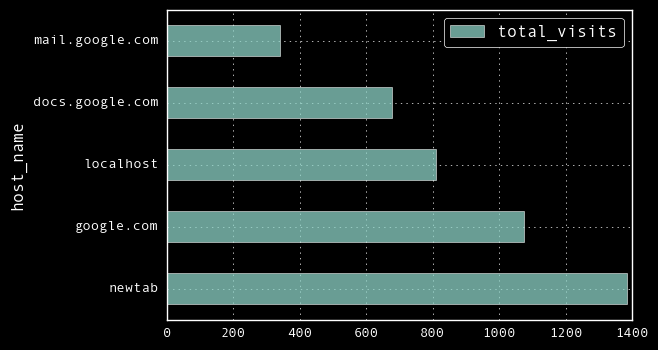

In [102]:
df[:5].plot(kind='barh', alpha=0.75)

### Create a pie chart to display data differently.

([<matplotlib.patches.Wedge at 0x111d5c240>,
  <matplotlib.text.Text at 0x111d7bda0>])

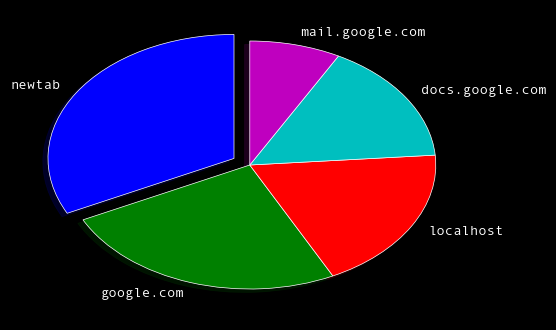

In [115]:
top_5_host_names = df.index[:5].values

# Math to get proper percentages.
arr_total_visits = np.array(df['total_visits'][:5].values)
sum_total_visits = np.sum(arr_total_visits)
arr_total_percen = arr_total_visits / sum_total_visits * 100

explode = (0.1, 0, 0, 0, 0)

plt.pie(x=arr_total_percen, explode=explode, labels=top_5_host_names, shadow=True, startangle=90)